In [1]:
from torchvision import models
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch
import pandas as pd
import numpy as np
import os

In [2]:
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

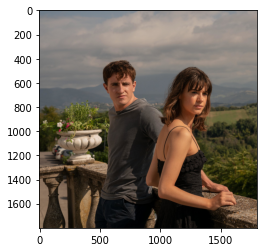

In [3]:
path = 'futopyshi/data/samples/3123.jpg'

img = Image.open(path)
plt.imshow(img)
plt.show()

In [4]:
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(),
                 T.Normalize(mean = [0.485, 0.456, 0.406],
                             std = [0.229, 0.224, 0.225])])

inp = trf(img).unsqueeze(0)

In [5]:
# move the input and model to GPU for speed if available
%time
if torch.cuda.is_available():
    inp = inp.to('cuda')
    fcn.to('cuda')

with torch.no_grad():
    output = fcn(inp)['out'][0]
output_predictions = output.argmax(0)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.9 µs


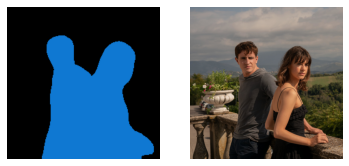

In [6]:
# create a color pallette, selecting a color for each class
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

# plot the semantic segmentation predictions of 21 classes in each color
r = Image.fromarray(output_predictions.byte().cpu().numpy()).resize(img.size)
r.putpalette(colors)

fig, ax = plt.subplots(1, 2)
ax[0].axis('off'), ax[1].axis('off')
ax[0].imshow(r)
ax[1].imshow(img)
plt.show()

In [7]:
print('Tensor format is (Batch x RGB x H x W)')
print(inp.shape)

Tensor format is (Batch x RGB x H x W)
torch.Size([1, 3, 224, 224])


In [8]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    """Disable gradient calculation for layers if feature extracting."""
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
import functools

def image_transpose_exif(im):
    """
    Apply Image.transpose to ensure 0th row of pixels is at the visual
    top of the image, and 0th column is the visual left-hand side.
    Return the original image if unable to determine the orientation.

    As per CIPA DC-008-2012, the orientation field contains an integer,
    1 through 8. Other values are reserved.

    Parameters
    ----------
    im: PIL.Image
       The image to be rotated.
    """

    exif_orientation_tag = 0x0112
    exif_transpose_sequences = [                   # Val  0th row  0th col
        [],                                        #  0    (reserved)
        [],                                        #  1   top      left
        [Image.FLIP_LEFT_RIGHT],                   #  2   top      right
        [Image.ROTATE_180],                        #  3   bottom   right
        [Image.FLIP_TOP_BOTTOM],                   #  4   bottom   left
        [Image.FLIP_LEFT_RIGHT, Image.ROTATE_90],  #  5   left     top
        [Image.ROTATE_270],                        #  6   right    top
        [Image.FLIP_TOP_BOTTOM, Image.ROTATE_90],  #  7   right    bottom
        [Image.ROTATE_90],                         #  8   left     bottom
    ]

    try:
        seq = exif_transpose_sequences[im._getexif()[exif_orientation_tag]]
    except Exception:
        return im
    else:
        return functools.reduce(type(im).transpose, seq, im)

In [146]:
from torch.utils.data import Dataset, DataLoader
import json

class FutoshikiGridDataset(Dataset):
    """Futoshiki Grid dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.grid_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.grid_frame.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.grid_frame.iloc[idx, 0])
        image = Image.open(img_name)
        image = image_transpose_exif(image)
        shape = image.size
        
        
        grid = self.grid_frame.loc[idx, 'region_shape_attributes']
        mask = get_mask(grid, shape)
        
#         grid = np.array([grid])
#         grid = grid.astype('float').reshape(-1, 2)
        sample = {'train': image, 'mask': mask}

        if self.transform:
            sample = {k: self.transform[k](v) for k, v in sample.items()}

        return sample
    
def get_mask(row, shape):
    row = json.loads(row)
    coords = [(x,y) for x, y in zip(row['all_points_x'], row['all_points_y'])]
    mask = Image.new('L', shape, 0)
    ImageDraw.Draw(mask).polygon(coords, outline=1, fill=1)
    mask = np.asarray(mask)
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = Image.fromarray(mask)
    return mask

In [147]:
input_size = 256
data_transforms = {
    'train': T.Compose([
        T.Resize(input_size),
        T.CenterCrop(input_size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.Resize(input_size),
        T.CenterCrop(input_size),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'mask': T.Compose([
        T.Resize(input_size),
        T.CenterCrop(input_size),
        T.ToTensor(),
        
    ])
}

In [148]:
grid_dataset = FutoshikiGridDataset('futopyshi/data/box_segmentation/annotations.csv', 'futopyshi/data/box_segmentation/grid/', data_transforms)

In [150]:
grid_dataset[0]

{'train': tensor([[[-0.1486, -0.3712, -0.2171,  ...,  0.4337,  0.4337,  0.4166],
          [ 0.0056, -0.0458,  0.1083,  ...,  0.3823,  0.3823,  0.3994],
          [ 0.5193,  0.6049,  0.5878,  ...,  0.3652,  0.3994,  0.3652],
          ...,
          [ 1.8208,  1.8037,  1.8208,  ...,  1.4612,  1.4440,  1.4612],
          [ 1.8379,  1.8208,  1.8379,  ...,  1.4269,  1.4098,  1.4954],
          [ 1.8379,  1.8208,  1.8208,  ...,  1.3927,  1.4269,  1.4612]],
 
         [[-0.1275, -0.3725, -0.2500,  ...,  0.3277,  0.3102,  0.2927],
          [-0.0049, -0.0574,  0.0826,  ...,  0.2752,  0.2752,  0.2927],
          [ 0.5203,  0.5553,  0.5378,  ...,  0.2752,  0.3277,  0.2752],
          ...,
          [ 1.9559,  1.9384,  1.9384,  ...,  1.5007,  1.5007,  1.5182],
          [ 1.9559,  1.9559,  1.9559,  ...,  1.4832,  1.4832,  1.5707],
          [ 1.9559,  1.9209,  1.9384,  ...,  1.4657,  1.5007,  1.5182]],
 
         [[-0.1661, -0.3753, -0.2358,  ...,  0.0256,  0.0082,  0.0082],
          [-0.0092,

In [129]:
len(grid_dataset)

14

In [132]:
np.where(out['mask'].numpy() > 0.004)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


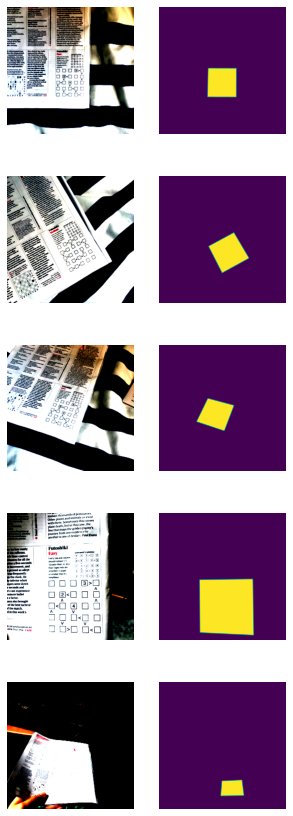

In [151]:
# print transformed samples and masks
rows = 5
fig, ax = plt.subplots(rows, 2, figsize=(5,15))

for x in range(rows):
    out = grid_dataset[x]
    ax[x][0].imshow(out['train'].numpy().transpose(1, 2, 0))
    ax[x][1].imshow(out['mask'].numpy().reshape(input_size, input_size))
    
    ax[x][0].axis('off'), ax[x][1].axis('off')

In [184]:
out['mask'].shape, out['train'].shape

(torch.Size([1, 256, 256]), torch.Size([3, 256, 256]))

In [19]:
plt.imshow(out['train'].numpy().reshape(256,256,3))

NameError: name 'out' is not defined

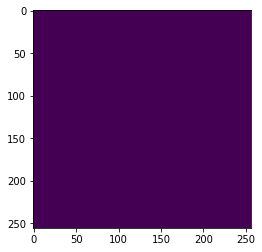

In [105]:
out = get_mask(annotations.loc[0, 'region_shape_attributes'], (256,256))
plt.imshow(out)

In [170]:
out['train']

tensor([[[-1.6727, -1.6555, -1.6384,  ..., -0.5596,  0.3994, -0.4226],
         [-1.6555, -1.6384, -1.6384,  ...,  0.7933,  0.8789,  0.6906],
         [-1.6213, -1.6213, -1.6384,  ...,  1.4954,  1.5639,  1.5297],
         ...,
         [-1.2274, -1.2445, -1.2103,  ...,  1.4612,  1.4269,  1.4269],
         [-1.2617, -1.2617, -1.2445,  ...,  1.4440,  1.4440,  1.4440],
         [-1.2445, -1.2445, -1.2445,  ...,  1.3927,  1.4269,  1.4440]],

        [[-1.4755, -1.4755, -1.4755,  ..., -0.4951,  0.4678, -0.3901],
         [-1.4755, -1.4755, -1.4755,  ...,  0.8704,  0.9405,  0.7654],
         [-1.4755, -1.4755, -1.4755,  ...,  1.5882,  1.6408,  1.6408],
         ...,
         [-1.1078, -1.1078, -1.1078,  ...,  1.4657,  1.4657,  1.4482],
         [-1.1429, -1.1429, -1.1253,  ...,  1.4482,  1.4657,  1.4657],
         [-1.1429, -1.1253, -1.1253,  ...,  1.3957,  1.4482,  1.4657]],

        [[-1.2990, -1.2816, -1.2641,  ..., -0.4798,  0.4788, -0.3404],
         [-1.2641, -1.2467, -1.2467,  ...,  0

In [109]:
out.size

(256, 256)

### Perform feature extraction on model

In [60]:
num_classes = 1
bs = 8
feature_extract = True
input_size = 256

In [51]:
print(fcn.classifier)

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 21, kernel_size=(1, 1), stride=(1, 1))
)


In [46]:
fcn.classifier[4] = torch.nn.Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))

In [47]:
print(fcn.classifier)

FCNHead(
  (0): Conv2d(2048, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
)


In [ ]:


print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}